In [3]:
x

In [1]:
#base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import matplotlib.image as mpimg
%matplotlib inline
from timeit import default_timer as timer
from tensorflow import keras

#image manipulation packages
import cv2
import os
from tqdm import tqdm
from glob import glob
from sklearn.metrics import confusion_matrix,classification_report

#Classification
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
sns.set()

import glob
import cv2
import shutil
import random
import Augmentor

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras import models
from tensorflow.keras.models import Sequential

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, GlobalMaxPooling2D



## RESNET50

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50


### Efficient
from tensorflow.keras.applications import EfficientNetB7


from PIL import Image
import PIL

import re

2022-11-01 13:38:40.519961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 13:38:40.630885: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-01 13:38:40.630899: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-01 13:38:40.655470: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-01 13:38:41.182370: W tensorflow/stream_executor/platform/de

In [7]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [8]:
print(gpu_devices)

[]


In [2]:
def crearDataset(path_expertAnotations,path_partialImages, dest_path):
    file = open(path_expertAnotations, 'r')
    os.mkdir(dest_path+'/data')
    os.mkdir(dest_path+'/data/01-Normal')
    os.mkdir(dest_path+'/data/02-Tapered')
    os.mkdir(dest_path+'/data/03-Pyriform')
    os.mkdir(dest_path+'/data/04-Small')
    os.mkdir(dest_path+'/data/05-Amorphous')

    categorias = ['01-Normal', '02-Tapered', '03-Pyriform', '04-Small', '05-Amorphous']

    for x in file:
        # Se obtiene el nombre y clase desde el archivo txt
        aux1 = x.split('	')
        clase = int(aux1[4].replace('\n',''))
        aux2 = aux1[0].replace('\n','').split('-')
        p = aux2[0]
        pl = aux2[1]
        aux3 = aux2[2].split('/')

        n_sample = int(re.split('(\d+)',aux3[0])[1])
        n_sperm = int(re.split('(\d+)',aux3[1])[1])
        # Se conforma el directorio de la imagen a partir de la informacion anterior.
        file = path_partialImages+'ch00_'+p+'-'+pl+'-sample'+str(n_sample)+'-sperm'+str(n_sperm)+'.tif'
        # Se conforma el directorio donde se va a copiar la imagen
        print(file)
        aux = dest_path+'/data/'
        if (clase == 0):
            aux=aux+'01-Normal'
        elif (clase == 1):
            aux=aux+'02-Tapered'
        elif (clase == 2):
            aux=aux+'03-Pyriform'
        elif (clase == 3):
            aux=aux+'04-Small'
        else:
            aux=aux+'05-Amorphous'

        # Se copia la imagen
        shutil.copy(file,aux)    


In [3]:
def fileCount(folder):
    "count the number of files in a directory"

    count = 0

    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)

        if os.path.isfile(path):
            count += 1
        elif os.path.isdir(path):
            count += fileCount(path)

    return count

In [ ]:
def crearSubConjuntos( nombre_clase, dir_clase, dest_dir):
    os.mkdir(dest_dir+"/train/"+nombre_clase)
    os.mkdir(dest_dir+"/test/"+nombre_clase)
    os.mkdir(dest_dir+"/valid/"+nombre_clase)
    
    lista = os.listdir(dir_clase)
    cantidad_imagenes = len(lista)
    contador = 0
    while (cantidad_imagenes*0.2) > contador:
        elemento = random.choice(lista)
        lista.remove(elemento)
        elemento = dir_clase+'/'+elemento
        shutil.copy(elemento,dest_dir+"/test/"+nombre_clase)
        contador = contador+1

    contador = 0
    while (cantidad_imagenes*0.2) > contador:
        elemento = random.choice(lista)
        lista.remove(elemento)
        elemento = dir_clase+'/'+elemento
        shutil.copy(elemento,dest_dir+"/valid/"+nombre_clase)
        contador = contador+1

    while len(lista) > 0:
        elemento = random.choice(lista)
        lista.remove(elemento)
        elemento = dir_clase+'/'+elemento
        shutil.copy(elemento,dest_dir+"/train/"+nombre_clase)
        contador = contador+1

def crearConjuntos( root_dir, dest_dir ):
    if os.path.exists(dest_dir+"/train"):
        shutil.rmtree(dest_dir+"/train")
    if os.path.exists(dest_dir+"/test"):
        shutil.rmtree(dest_dir+"/test")
    if os.path.exists(dest_dir+"/valid"):
        shutil.rmtree(dest_dir+"/valid")
    os.mkdir(dest_dir+"/train")
    os.mkdir(dest_dir+"/test")
    os.mkdir(dest_dir+"/valid")
    crearSubConjuntos( '01-Normal', root_dir+'/01-Normal', dest_dir )
    crearSubConjuntos( '02-Tapered', root_dir+'/02-Tapered', dest_dir )
    crearSubConjuntos( '03-Pyriform', root_dir+'/03-Pyriform', dest_dir )
    crearSubConjuntos( '04-Small', root_dir+'/04-Small', dest_dir )
    crearSubConjuntos( '05-Amorphous', root_dir+'/05-Amorphous', dest_dir )

In [5]:
def copyImageFromList( root_dir, dest_dir, image_list ):
        element = random.choice(image_list)
        image_list.remove(element)
        element = root_dir+'/'+class_name+'/'+element
        shutil.copy(element,dest_dir+'/'+class_name)       

In [6]:
def generate_kFold_classImages( class_name, root_dir, list_paths, valid_path):
    images_in_folder = os.listdir(root_dir+'/'+class_name)
    len_images = len(images_in_folder)
    percentage_per_fold = (100/len(list_paths))/100

    for i in range(len(list_paths)):
        dest_dir = list_paths[i]
        if (i == 0):
            count = 0
            while (len_images*percentage_per_fold)*0.2 > count:
                element = random.choice(images_in_folder)
                images_in_folder.remove(element)
                element = root_dir+'/'+class_name+'/'+element
                shutil.copy(element,valid_path+'/'+class_name)  
                count = count+1 
            count = 0
            while (len_images*percentage_per_fold)*0.8 > count:
                element = random.choice(images_in_folder)
                images_in_folder.remove(element)
                element = root_dir+'/'+class_name+'/'+element
                shutil.copy(element,dest_dir+'/'+class_name)  
                count = count+1
                
        elif ( i ==  len(list_paths)-1):
            while len(images_in_folder) > 0:
                element = random.choice(images_in_folder)
                images_in_folder.remove(element)
                element = root_dir+'/'+class_name+'/'+element
                shutil.copy(element,dest_dir+'/'+class_name)                
        else:
            count = 0
            while (len_images*percentage_per_fold) > count:
                element = random.choice(images_in_folder)
                images_in_folder.remove(element)
                element = root_dir+'/'+class_name+'/'+element
                shutil.copy(element,dest_dir+"/"+class_name)
                count = count+1            
    

In [4]:
crearDataset("/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/PA-expert-annotations.txt", '/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/Partial-Agreement-Images/',"/home/mcoronado/Escritorio/Codigo-Memoria/Data-set")


FileExistsError: [Errno 17] File exists: '/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/data'

In [7]:
def generate_kFold_partitionImages( original_dir,dest_dir, k_folds ):
    percentage_per_fold = int(100/k_folds)
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)   
    os.mkdir(dest_dir)
    
    list_paths = []
    for i in range(0,k_folds+1):
        if (i == 0):
            ifold_fileName = 'valid'
        else:
            ifold_fileName = 'fold_'+str(i)
        ifold_path = dest_dir+ifold_fileName
        if os.path.exists(ifold_path):
            shutil.rmtree(ifold_path)
        os.mkdir(ifold_path)
        os.mkdir(ifold_path+'/01-Normal')
        os.mkdir(ifold_path+'/02-Tapered')
        os.mkdir(ifold_path+'/03-Pyriform')
        os.mkdir(ifold_path+'/04-Small')
        os.mkdir(ifold_path+'/05-Amorphous')
        if( i!= 0):
            list_paths.append(ifold_path)
    valid_path = dest_dir+'valid'
    generate_kFold_classImages( '01-Normal', original_dir, list_paths, valid_path)
    generate_kFold_classImages( '02-Tapered', original_dir, list_paths, valid_path)
    generate_kFold_classImages( '03-Pyriform', original_dir, list_paths, valid_path)
    generate_kFold_classImages( '04-Small', original_dir, list_paths, valid_path)
    generate_kFold_classImages( '05-Amorphous', original_dir, list_paths, valid_path)
    return list_paths
        


In [8]:
def eliminarImagenesAumentadas( image_dir ):
    class_names = ['01-Normal', '02-Tapered', '03-Pyriform', '04-Small', '05-Amorphous']
    for class_name in class_names:
        if os.path.exists(image_dir+'/'+class_name+'/output'):
            shutil.rmtree(image_dir+'/'+class_name+'/output')    

In [10]:
def k_fold_dataAugmentation( kfold_paths , n_images_target):
    for i in range(len(kfold_paths)):
        if (i == 0):
            aumentarImagenesSCIAN( kfold_paths[i] ,int(n_images_target*0.80) )
        else:
            aumentarImagenesSCIAN( kfold_paths[i] ,n_images_target )
    

In [11]:
def k_fold_dataAugmentation_delete( kfold_paths ):
    for i in range(len(kfold_paths)):
        eliminarImagenesAumentadas( kfold_paths[i] )    

In [13]:
def k_fold_moveTrainImages(n_kfold, kfold_paths, dest_dir):
    # [nombreImagen, path_fold, original/aumentada]
    all_images_objects = []
    classes_names = ['01-Normal', '02-Tapered', '03-Pyriform', '04-Small', '05-Amorphous']
    if os.path.exists(dest_dir+'/train'):
        shutil.rmtree(dest_dir+'/train')   
    os.mkdir(dest_dir+"/train")
    for class_name in classes_names:
        os.mkdir(dest_dir+"/train/"+class_name)
        os.mkdir(dest_dir+"/train/"+class_name+'/output')
    for i in range(0,len(kfold_paths)):
        if (i != n_kfold-1):
            path = kfold_paths[i]
            for class_name in classes_names:
                class_path = path+'/'+class_name
                image_names= os.listdir(class_path)
                for image in image_names:
                    if image.endswith(".tif"):
                        image_dir = class_path+'/'+image
                        all_images_objects.append([image, class_path, 'original'])
                        shutil.move( image_dir, dest_dir+'train/'+class_name)

                augmentated_image_names= os.listdir(class_path+'/output')
                for image in augmentated_image_names:
                    if image.endswith(".tif"):
                        image_dir = class_path+'/output/'+image
                        all_images_objects.append([image, class_path+'/output', 'augmented'])
                        shutil.move( image_dir, dest_dir+'train/'+class_name+'/output')
    return all_images_objects

In [9]:
def generate_kFold_validation( root_dir ):
    root_dir = root_dir+'valid'
    if os.path.exists(root_dir):
        shutil.rmtree(root_dir)   
    os.mkdir(root_dir)
    

In [15]:
#k_folds = 5
#list_kfold_paths = generate_kFold_partitionImages( original_dir='/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/data/', dest_dir='/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/', k_folds= k_folds)
#k_fold_dataAugmentation(list_kfold_paths,1600)
#k_fold_moveTrainImages(1,list_kfold_paths,'/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/')

In [12]:
def read_train_kfold( n_fold , root_dir):
    
    return data_gen

In [17]:
def contarArchivos(folder):
    count = 0
    for root_dir, cur_dir, files in os.walk(folder):
        count += len(files)
    return count

In [14]:
def k_fold_returnTrainImages( n_kfold, kfold_paths):
    print('w')

In [523]:
k_fold_dataAugmentation_delete( list_kfold_paths ) 

In [16]:
def k_fold_returnTrainImages(n_kfold, kfold_paths, des_dir,all_dir_object):

SyntaxError: unexpected EOF while parsing (3892630249.py, line 1)

In [18]:
# https://github.com/mdbloice/Augmentor/issues/125#issuecomment-410978015
from Augmentor.Operations import Operation
class TranslateImage(Operation):
    # Here you can accept as many custom parameters as required:
    def __init__(self, probability,max_left_translation,max_right_translation,max_down_translation,max_up_translation):
        # Call the superclass's constructor (meaning you must
        # supply a probability value):
        Operation.__init__(self, probability)
        # Set your custom operation's member variables here as required:
        self.max_left_translation = -abs(max_left_translation)
        self.max_right_translation = max_right_translation
        self.max_down_translation = -abs(max_down_translation)
        self.max_up_translation = max_up_translation

    # Your class must implement the perform_operation method:
    def perform_operation(self, images):
        # Start of code to perform custom image operation.
        def do(image):
            random_left = random.randint(self.max_left_translation, 0)
            random_right = random.randint(0, self.max_right_translation)
            left_or_right = random.randint(0, 1)
            translation_left_right = 0
            if left_or_right == 0:
                translation_left_right= random_left
            elif left_or_right == 1:
                translation_left_right = random_right
            
            random_down = random.randint(self.max_down_translation, 0)
            random_up = random.randint(0, self.max_up_translation)
            up_or_down = random.randint(0, 1)
            translation_up_down = 0
            if up_or_down == 0:
                translation_up_down = random_up
            elif up_or_down == 1:
                translation_up_down = random_down
            a = 1
            b = 0
            c = translation_left_right #left/right (i.e. 5/-5)
            d = 0
            e = 1
            f = translation_up_down  #up/down (i.e. 5/-5)
            #image = PIL.Image.fromarray(image)
            image = image.transform(image.size, PIL.Image.AFFINE, (a, b, c, d, e, f))
            return image
        
        augmented_images = []

        for image in images:
            augmented_images.append(do(image))

        return augmented_images

In [19]:
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)


In [147]:
## Diagnotics-10-00325
def aumentarImagenesSCIAN(data_path, cantidad_imagenes):
    #counts number of images in training data
    cantidad_train_1= contarArchivos(data_path+'/01-Normal')
    cantidad_train_2 = contarArchivos(data_path+'/02-Tapered')
    cantidad_train_3 = contarArchivos(data_path+'/03-Pyriform')
    cantidad_train_4 = contarArchivos(data_path+'/04-Small')
    cantidad_train_5 = contarArchivos(data_path+'/05-Amorphous')

    ## Se instancia un Augmentor
    pipeline_normal = Augmentor.Pipeline(data_path+'/01-Normal')
    pipeline_tapered = Augmentor.Pipeline(data_path+'/02-Tapered')
    pipeline_pyriform = Augmentor.Pipeline(data_path+'/03-Pyriform')
    pipeline_small = Augmentor.Pipeline(data_path+'/04-Small')
    pipeline_morphous = Augmentor.Pipeline(data_path+'/05-Amorphous')

    ## Rotation -25° a 25°
    pipeline_normal.rotate_without_crop(probability=0.6, max_left_rotation=5, max_right_rotation=5)
    pipeline_tapered.rotate_without_crop(probability=0.6, max_left_rotation=5, max_right_rotation=5)
    pipeline_pyriform.rotate_without_crop(probability=0.6, max_left_rotation=5, max_right_rotation=5)
    pipeline_small.rotate_without_crop(probability=0.6, max_left_rotation=5, max_right_rotation=5)
    pipeline_morphous.rotate_without_crop(probability=0.6, max_left_rotation=5, max_right_rotation=5)

    ## Vertical flip
    pipeline_normal.flip_top_bottom(probability=0.6)
    pipeline_tapered.flip_top_bottom(probability=0.6)
    pipeline_pyriform.flip_top_bottom(probability=0.6)
    pipeline_small.flip_top_bottom(probability=0.6)
    pipeline_morphous.flip_top_bottom(probability=0.6)

    ## Trasladation (max 6% de la imagen = 3 pixeles )
    pipeline_normal.add_operation(TranslateImage(probability = 0.6, max_left_translation=3,max_right_translation=3,max_down_translation=3,max_up_translation=3))
    pipeline_tapered.add_operation(TranslateImage(probability = 0.6, max_left_translation=3,max_right_translation=3,max_down_translation=3,max_up_translation=3))
    pipeline_pyriform.add_operation(TranslateImage(probability = 0.6, max_left_translation=3,max_right_translation=3,max_down_translation=3,max_up_translation=3))
    pipeline_small.add_operation(TranslateImage(probability = 0.6, max_left_translation=3,max_right_translation=3,max_down_translation=3,max_up_translation=3))
    pipeline_morphous.add_operation(TranslateImage(probability = 0.6, max_left_translation=3,max_right_translation=3,max_down_translation=3,max_up_translation=3))

    # Se restan para asimilar la distribucion original de las imagenes.
    pipeline_normal.sample(cantidad_imagenes - cantidad_train_1)
    pipeline_tapered.sample(cantidad_imagenes - cantidad_train_2)
    pipeline_pyriform.sample(cantidad_imagenes - cantidad_train_3)
    pipeline_small.sample(cantidad_imagenes - cantidad_train_4)
    pipeline_morphous.sample(cantidad_imagenes - cantidad_train_5)
    
    
    

In [164]:
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
def crearDataGenerators(data_path):
    
    dataGen_train = ImageDataGenerator(rescale = 1./255,preprocessing_function= preprocess_input) 
    dataGen_valid = ImageDataGenerator(rescale = 1./255,preprocessing_function= preprocess_input)
    dataGen_test = ImageDataGenerator(rescale = 1./255,preprocessing_function= preprocess_input)

    #test different color maps -  class modes and cross validation types
    train = dataGen_train.flow_from_directory(data_path+'/train',
                                                     target_size = (35, 35),
                                                     batch_size = 256,
                                                     shuffle = True,
                                                     class_mode="categorical")

    valid = dataGen_valid.flow_from_directory(data_path+'/valid',
                                                target_size = (35, 35),
                                                batch_size = 64,
                                                shuffle = True,
                                                class_mode="categorical")

    test = dataGen_test.flow_from_directory(data_path+'/test',
                                                target_size = (35, 35),
                                                batch_size = 1,
                                                shuffle = True,
                                                class_mode="categorical")
    return train,valid,test

In [22]:
def crearCNN_simple():
    #creating a model that will take inputs 32,32,1
    cnn_model = Sequential()

    #convolutional layer with 32 2x2 filters - output 14 x 14 active area
    cnn_model.add(Conv2D(filters=35, kernel_size=(4,4), padding = 'same', activation='relu')) 
    cnn_model.add(BatchNormalization())

    #2nd convolution with 64 filters  
    cnn_model.add(Conv2D(filters=64, kernel_size=(2,2), padding = 'same', activation= 'relu'))
    cnn_model.add(BatchNormalization())  

    #MaxPooling - takes the max value of each 2x2 pool in the feature map
    cnn_model.add(MaxPooling2D(pool_size=(2,2)))
    cnn_model.add(BatchNormalization())

    #the result of kthe CNN is then flattened and placed into the 
    cnn_model.add(Flatten())
    cnn_model.add(Dense(576, activation='relu'))
    cnn_model.add(BatchNormalization())

    #widen layer
    cnn_model.add(Dense(1024, activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.5))


    #shrink layer
    cnn_model.add(Dense(256, activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.5))

    cnn_model.add(Dense(5))
    cnn_model.add(BatchNormalization())            
    cnn_model.add(Activation('softmax'))

    cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return cnn_model

In [23]:
def entrenarModelo(modelo, epochs, train_data, valid_data, callbacks):
    history = modelo.fit(train_data,
            epochs=epochs, 
            validation_data=valid_data,
            verbose = 1, 
            callbacks = callbacks) 
    return history

In [155]:
# https://keras.io/api/callbacks/
# Se utilizo como referencia el trabajo de Ricardo Santos.
def crearCallBacks(checkpoint_path):

    #https://keras.io/api/callbacks/model_checkpoint/
    model_checkPoint = ModelCheckpoint(filepath=checkpoint_path, verbose = 1, monitor='val_accuracy', mode='max', save_best_only=True)

    #https://keras.io/api/callbacks/early_stopping/
    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights = True)

    #https://keras.io/api/callbacks/reduce_lr_on_plateau/
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0, verbose = 1)

    cb = TimingCallback()    
    return [model_checkPoint, cb]

In [139]:
def imprimirMetricas(y_train, pred_train , y_val, pred_val):
    print( " Conjunto train "+"\n")
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train)+"\n")
    print( " Conjunto valid "+"\n")
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val)+"\n")

In [140]:
def evaluarModelo( modelo, test):
    test_loss, test_acc = modelo.evaluate(test)
    print('Test loss:', test_loss)
    print('Test accuracy:', test_acc)
    #print("\nTime:",sum(modelo.callbacks.cb.logs)/60,"min")    
    
    prediction = modelo.predict( test )
    clase_predecida = np.argmax(prediction,axis=1)
    clase_verdadera = test.classes
    class_labels = list(test.class_indices.keys())   
    
    print(confusion_matrix(clase_verdadera, clase_predecida))
    print(classification_report(clase_verdadera, clase_predecida, target_names=class_labels))
    

In [141]:
def balancearValid( original_dir, obj_class_name):
    classes_names = ['01-Normal', '02-Tapered', '03-Pyriform', '04-Small', '05-Amorphous']
    valid_dir = original_dir+'/valid'
    train_dir = original_dir+'/train'
    
    count_obj_class = contarArchivos(valid_dir+obj_class_name)
    
    for class_name in classes_names:
        images_names = os.listdir(valid_dir+'/'+class_name)
        while len(images_names) > count_obj_class:
            element = random.choice(images_names)
            images_names.remove(element)
            element_dir=valid_dir+'/'+class_name+'/'+element
            shutil.move(element_dir, train_dir+'/'+class_name)

In [165]:
#crearDataset("/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/PA-expert-annotations.txt", '/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/Partial-Agreement-Images/',"/home/mcoronado/Escritorio/Codigo-Memoria/Data-set")
#crearConjuntos('/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/data','/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/final_data')
#aumentarImagenesSCIAN('/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/final_data/train', 6400)
#balancearValid('/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/final_data','/04-Small')
train,valid,test = crearDataGenerators('/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/final_data')

Found 32000 images belonging to 5 classes.
Found 75 images belonging to 5 classes.
Found 229 images belonging to 5 classes.


In [150]:
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Model


def generateVGG16(input_shape, n_classes, fine_tune=0):
    base_model = VGG16(weights="imagenet", include_top=False, input_tensor=input_shape)
    if( fine_tune > 0):
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = False    
    top_model = base_model.output
    top_model = Flatten(name='flatten')(top_model)
    top_model = Dense(128, activation='relu')(top_model)
    top_model = Dropout(0.05)(top_model)
    
    top_model = Dense(64, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    final_model = Model(inputs=base_model.input, outputs=output_layer)

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0005,
        decay_steps=10000,
        decay_rate=0.0055)
    
    final_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return final_model
    #flatten_layer = layers.Flatten()
    #dense_layer_1 = layers.Dense(1024, activation='relu')
    #dense_layer_2 = layers.Dense(512, activation='relu')
    #prediction_layer = layers.Dense(5, activation='softmax')

    #final_mode = models.Sequential([
    #    base_model,
    #    flatten_layer,
    #    dense_layer_1,
    #    dense_layer_2,
    #    prediction_layer
    #])
    #final_mode.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    #              loss='categorical_crossentropy',
    #              metrics=['accuracy'])


In [151]:
# ACA

In [152]:
vgg16_model = generateVGG16(Input(shape=(35, 35, 3)), 5, 0)

In [93]:
vgg16_model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 35, 35, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 35, 35, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 35, 35, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 17, 17, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 17, 17, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 17, 17, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0  

In [166]:
callbacks = crearCallBacks('/home/mcoronado/Escritorio/Models_VGG16_V6')
model_history11 = entrenarModelo(vgg16_model, 200, train, valid, callbacks )

Epoch 1/200
125/125 [==============================] - ETA: 0s - loss: 0.5675 - accuracy: 0.7862
Epoch 1: val_accuracy improved from -inf to 0.52000, saving model to /home/mcoronado/Escritorio/Models_VGG16_V6


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V6/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V6/assets


125/125 [==============================] - 98s 786ms/step - loss: 0.5675 - accuracy: 0.7862 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 2/200
125/125 [==============================] - ETA: 0s - loss: 0.5631 - accuracy: 0.7909
Epoch 2: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 566ms/step - loss: 0.5631 - accuracy: 0.7909 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 3/200
125/125 [==============================] - ETA: 0s - loss: 0.5659 - accuracy: 0.7881
Epoch 3: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 565ms/step - loss: 0.5659 - accuracy: 0.7881 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 4/200
125/125 [==============================] - ETA: 0s - loss: 0.5665 - accuracy: 0.7867
Epoch 4: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 565ms/step - loss: 0.5665 - accuracy: 0.7867 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 5/200
125/125 

125/125 [==============================] - 71s 565ms/step - loss: 0.5688 - accuracy: 0.7882 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 31/200
125/125 [==============================] - ETA: 0s - loss: 0.5681 - accuracy: 0.7874
Epoch 31: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 565ms/step - loss: 0.5681 - accuracy: 0.7874 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 32/200
125/125 [==============================] - ETA: 0s - loss: 0.5653 - accuracy: 0.7901
Epoch 32: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 565ms/step - loss: 0.5653 - accuracy: 0.7901 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 33/200
125/125 [==============================] - ETA: 0s - loss: 0.5653 - accuracy: 0.7892
Epoch 33: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 566ms/step - loss: 0.5653 - accuracy: 0.7892 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 34/200
1

125/125 [==============================] - 71s 566ms/step - loss: 0.5655 - accuracy: 0.7885 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 60/200
125/125 [==============================] - ETA: 0s - loss: 0.5648 - accuracy: 0.7887
Epoch 60: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 566ms/step - loss: 0.5648 - accuracy: 0.7887 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 61/200
125/125 [==============================] - ETA: 0s - loss: 0.5677 - accuracy: 0.7858
Epoch 61: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 566ms/step - loss: 0.5677 - accuracy: 0.7858 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 62/200
125/125 [==============================] - ETA: 0s - loss: 0.5684 - accuracy: 0.7864
Epoch 62: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 566ms/step - loss: 0.5684 - accuracy: 0.7864 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 63/200
1

125/125 [==============================] - 71s 565ms/step - loss: 0.5672 - accuracy: 0.7868 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 89/200
125/125 [==============================] - ETA: 0s - loss: 0.5671 - accuracy: 0.7862
Epoch 89: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 565ms/step - loss: 0.5671 - accuracy: 0.7862 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 90/200
125/125 [==============================] - ETA: 0s - loss: 0.5688 - accuracy: 0.7856
Epoch 90: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 565ms/step - loss: 0.5688 - accuracy: 0.7856 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 91/200
125/125 [==============================] - ETA: 0s - loss: 0.5668 - accuracy: 0.7869
Epoch 91: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 565ms/step - loss: 0.5668 - accuracy: 0.7869 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 92/200
1

125/125 [==============================] - ETA: 0s - loss: 0.5696 - accuracy: 0.7878
Epoch 117: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 565ms/step - loss: 0.5696 - accuracy: 0.7878 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 118/200
125/125 [==============================] - ETA: 0s - loss: 0.5647 - accuracy: 0.7881
Epoch 118: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 570ms/step - loss: 0.5647 - accuracy: 0.7881 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 119/200
125/125 [==============================] - ETA: 0s - loss: 0.5639 - accuracy: 0.7903
Epoch 119: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 566ms/step - loss: 0.5639 - accuracy: 0.7903 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 120/200
125/125 [==============================] - ETA: 0s - loss: 0.5686 - accuracy: 0.7883
Epoch 120: val_accuracy did not improve from 0.52000
125/

Epoch 146/200
125/125 [==============================] - ETA: 0s - loss: 0.5662 - accuracy: 0.7878
Epoch 146: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 565ms/step - loss: 0.5662 - accuracy: 0.7878 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 147/200
125/125 [==============================] - ETA: 0s - loss: 0.5657 - accuracy: 0.7884
Epoch 147: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 565ms/step - loss: 0.5657 - accuracy: 0.7884 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 148/200
125/125 [==============================] - ETA: 0s - loss: 0.5657 - accuracy: 0.7891
Epoch 148: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 567ms/step - loss: 0.5657 - accuracy: 0.7891 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 149/200
125/125 [==============================] - ETA: 0s - loss: 0.5649 - accuracy: 0.7868
Epoch 149: val_accuracy did not improve fro

Epoch 175/200
125/125 [==============================] - ETA: 0s - loss: 0.5666 - accuracy: 0.7866
Epoch 175: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 567ms/step - loss: 0.5666 - accuracy: 0.7866 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 176/200
125/125 [==============================] - ETA: 0s - loss: 0.5633 - accuracy: 0.7895
Epoch 176: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 565ms/step - loss: 0.5633 - accuracy: 0.7895 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 177/200
125/125 [==============================] - ETA: 0s - loss: 0.5682 - accuracy: 0.7874
Epoch 177: val_accuracy did not improve from 0.52000
125/125 [==============================] - 71s 566ms/step - loss: 0.5682 - accuracy: 0.7874 - val_loss: 1.4394 - val_accuracy: 0.5200
Epoch 178/200
125/125 [==============================] - ETA: 0s - loss: 0.5683 - accuracy: 0.7845
Epoch 178: val_accuracy did not improve fro

In [167]:
evaluarModelo(vgg16_model, test)

229/229 [==============================] - 2s 9ms/step - loss: 1.1566 - accuracy: 0.5022
Test loss: 1.1566131114959717
Test accuracy: 0.5021833777427673
229/229 [==============================] - 2s 8ms/step
[[ 1  4  5  0 10]
 [ 7 10  2  5 22]
 [ 4  4  1  2  5]
 [ 2  6  2  0  5]
 [16 37 15 11 53]]
              precision    recall  f1-score   support

   01-Normal       0.03      0.05      0.04        20
  02-Tapered       0.16      0.22      0.19        46
 03-Pyriform       0.04      0.06      0.05        16
    04-Small       0.00      0.00      0.00        15
05-Amorphous       0.56      0.40      0.47       132

    accuracy                           0.28       229
   macro avg       0.16      0.15      0.15       229
weighted avg       0.36      0.28      0.31       229



In [144]:
callbacks = crearCallBacks('/home/mcoronado/Escritorio/Models_VGG16_V2')
model_history11 = entrenarModelo(vgg16_model, 200, train, valid, callbacks )

Epoch 1/200
32/32 [==============================] - ETA: 0s - loss: 1.5533 - accuracy: 0.3062
Epoch 1: val_accuracy improved from -inf to 0.41333, saving model to /home/mcoronado/Escritorio/Models_VGG16_V2


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V2/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V2/assets


32/32 [==============================] - 114s 4s/step - loss: 1.5533 - accuracy: 0.3062 - val_loss: 1.3993 - val_accuracy: 0.4133
Epoch 2/200
32/32 [==============================] - ETA: 0s - loss: 1.3708 - accuracy: 0.4281
Epoch 2: val_accuracy improved from 0.41333 to 0.50667, saving model to /home/mcoronado/Escritorio/Models_VGG16_V2


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V2/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V2/assets


32/32 [==============================] - 74s 2s/step - loss: 1.3708 - accuracy: 0.4281 - val_loss: 1.2150 - val_accuracy: 0.5067
Epoch 3/200
32/32 [==============================] - ETA: 0s - loss: 1.2483 - accuracy: 0.4802
Epoch 3: val_accuracy improved from 0.50667 to 0.53333, saving model to /home/mcoronado/Escritorio/Models_VGG16_V2


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V2/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V2/assets


32/32 [==============================] - 74s 2s/step - loss: 1.2483 - accuracy: 0.4802 - val_loss: 1.1346 - val_accuracy: 0.5333
Epoch 4/200
32/32 [==============================] - ETA: 0s - loss: 1.1711 - accuracy: 0.5210
Epoch 4: val_accuracy did not improve from 0.53333
32/32 [==============================] - 71s 2s/step - loss: 1.1711 - accuracy: 0.5210 - val_loss: 1.1033 - val_accuracy: 0.5333
Epoch 5/200
32/32 [==============================] - ETA: 0s - loss: 1.1107 - accuracy: 0.5549
Epoch 5: val_accuracy did not improve from 0.53333
32/32 [==============================] - 72s 2s/step - loss: 1.1107 - accuracy: 0.5549 - val_loss: 1.0773 - val_accuracy: 0.5333
Epoch 6/200
32/32 [==============================] - ETA: 0s - loss: 1.0684 - accuracy: 0.5675
Epoch 6: val_accuracy improved from 0.53333 to 0.54667, saving model to /home/mcoronado/Escritorio/Models_VGG16_V2


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V2/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V2/assets


32/32 [==============================] - 73s 2s/step - loss: 1.0684 - accuracy: 0.5675 - val_loss: 1.0753 - val_accuracy: 0.5467
Epoch 7/200
32/32 [==============================] - ETA: 0s - loss: 1.0337 - accuracy: 0.5864
Epoch 7: val_accuracy did not improve from 0.54667
32/32 [==============================] - 71s 2s/step - loss: 1.0337 - accuracy: 0.5864 - val_loss: 1.0619 - val_accuracy: 0.5067
Epoch 8/200
32/32 [==============================] - ETA: 0s - loss: 0.9992 - accuracy: 0.6048
Epoch 8: val_accuracy did not improve from 0.54667
32/32 [==============================] - 71s 2s/step - loss: 0.9992 - accuracy: 0.6048 - val_loss: 1.0824 - val_accuracy: 0.4933
Epoch 9/200
32/32 [==============================] - ETA: 0s - loss: 0.9722 - accuracy: 0.6203
Epoch 9: val_accuracy did not improve from 0.54667
32/32 [==============================] - 71s 2s/step - loss: 0.9722 - accuracy: 0.6203 - val_loss: 1.0399 - val_accuracy: 0.4933
Epoch 10/200
32/32 [==========================

In [146]:
evaluarModelo(vgg16_model, test)

229/229 [==============================] - 3s 9ms/step - loss: 1.1539 - accuracy: 0.5153
Test loss: 1.1538959741592407
Test accuracy: 0.5152838230133057
229/229 [==============================] - 3s 9ms/step
[[ 1  2  4  1 12]
 [ 4  5 10  2 25]
 [ 5  2  3  1  5]
 [ 2  1  3  4  5]
 [13 14 28 12 65]]
              precision    recall  f1-score   support

   01-Normal       0.04      0.05      0.04        20
  02-Tapered       0.21      0.11      0.14        46
 03-Pyriform       0.06      0.19      0.09        16
    04-Small       0.20      0.27      0.23        15
05-Amorphous       0.58      0.49      0.53       132

    accuracy                           0.34       229
   macro avg       0.22      0.22      0.21       229
weighted avg       0.40      0.34      0.36       229



In [110]:
callbacks = crearCallBacks('/home/mcoronado/Escritorio/Models_VGG16_V2')
model_history11 = entrenarModelo(vgg16_model, 200, train, valid, callbacks )

Epoch 1/200
52/52 [==============================] - ETA: 0s - loss: 0.7055 - accuracy: 0.7271
Epoch 1: val_accuracy improved from -inf to 0.52000, saving model to /home/mcoronado/Escritorio/Models_VGG16_V2


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V2/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V2/assets


52/52 [==============================] - 10s 191ms/step - loss: 0.7055 - accuracy: 0.7271 - val_loss: 1.1023 - val_accuracy: 0.5200 - lr: 5.0000e-04
Epoch 2/200
52/52 [==============================] - ETA: 0s - loss: 0.7017 - accuracy: 0.7268
Epoch 2: val_accuracy improved from 0.52000 to 0.53333, saving model to /home/mcoronado/Escritorio/Models_VGG16_V2


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V2/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V2/assets


52/52 [==============================] - 10s 199ms/step - loss: 0.7017 - accuracy: 0.7268 - val_loss: 1.1120 - val_accuracy: 0.5333 - lr: 5.0000e-04
Epoch 3/200
52/52 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.7299
Epoch 3: val_accuracy did not improve from 0.53333
52/52 [==============================] - 8s 151ms/step - loss: 0.6902 - accuracy: 0.7299 - val_loss: 1.1335 - val_accuracy: 0.4667 - lr: 5.0000e-04
Epoch 4/200
52/52 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.7369
Epoch 4: val_accuracy did not improve from 0.53333
52/52 [==============================] - 8s 154ms/step - loss: 0.6869 - accuracy: 0.7369 - val_loss: 1.0702 - val_accuracy: 0.4800 - lr: 5.0000e-04
Epoch 5/200
52/52 [==============================] - ETA: 0s - loss: 0.6624 - accuracy: 0.7473
Epoch 5: val_accuracy did not improve from 0.53333
52/52 [==============================] - 8s 151ms/step - loss: 0.6624 - accuracy: 0.7473 - val_loss: 1.2884 - val_acc

INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V2/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V2/assets


52/52 [==============================] - 10s 192ms/step - loss: 0.6688 - accuracy: 0.7341 - val_loss: 1.2039 - val_accuracy: 0.5600 - lr: 5.0000e-04
Epoch 7/200
52/52 [==============================] - ETA: 0s - loss: 0.6491 - accuracy: 0.7518
Epoch 7: val_accuracy did not improve from 0.56000
52/52 [==============================] - 8s 152ms/step - loss: 0.6491 - accuracy: 0.7518 - val_loss: 1.1678 - val_accuracy: 0.5467 - lr: 5.0000e-04
Epoch 8/200
52/52 [==============================] - ETA: 0s - loss: 0.6419 - accuracy: 0.7518
Epoch 8: val_accuracy did not improve from 0.56000
52/52 [==============================] - 8s 156ms/step - loss: 0.6419 - accuracy: 0.7518 - val_loss: 1.2447 - val_accuracy: 0.5333 - lr: 5.0000e-04
Epoch 9/200
52/52 [==============================] - ETA: 0s - loss: 0.6207 - accuracy: 0.7689
Epoch 9: val_accuracy did not improve from 0.56000

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
52/52 [==============================] -

In [31]:
print(vgg16_model)

In [111]:
evaluarModelo(vgg16_model, test)

229/229 [==============================] - 2s 9ms/step - loss: 1.1299 - accuracy: 0.5371
Test loss: 1.1298741102218628
Test accuracy: 0.5371178984642029
229/229 [==============================] - 2s 9ms/step
[[ 4  5  2  2  7]
 [ 4 12  4  2 24]
 [ 4  0  4  1  7]
 [ 3  4  2  0  6]
 [26 18 19  9 60]]
              precision    recall  f1-score   support

   01-Normal       0.10      0.20      0.13        20
  02-Tapered       0.31      0.26      0.28        46
 03-Pyriform       0.13      0.25      0.17        16
    04-Small       0.00      0.00      0.00        15
05-Amorphous       0.58      0.45      0.51       132

    accuracy                           0.35       229
   macro avg       0.22      0.23      0.22       229
weighted avg       0.41      0.35      0.37       229



In [119]:
callbacks = crearCallBacks('/home/mcoronado/Escritorio/Models_VGG16_V3')
model_history12 = entrenarModelo(vgg16_model, 200, train, valid, callbacks )

Epoch 1/200
48/48 [==============================] - ETA: 0s - loss: 1.5139 - accuracy: 0.4659
Epoch 1: val_accuracy improved from -inf to 0.50667, saving model to /home/mcoronado/Escritorio/Models_VGG16_V3


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V3/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V3/assets


48/48 [==============================] - 10s 210ms/step - loss: 1.5139 - accuracy: 0.4659 - val_loss: 1.0167 - val_accuracy: 0.5067 - lr: 3.1250e-05
Epoch 2/200
48/48 [==============================] - ETA: 0s - loss: 1.3176 - accuracy: 0.4856
Epoch 2: val_accuracy did not improve from 0.50667
48/48 [==============================] - 8s 163ms/step - loss: 1.3176 - accuracy: 0.4856 - val_loss: 1.0316 - val_accuracy: 0.5067 - lr: 3.1250e-05
Epoch 3/200
48/48 [==============================] - ETA: 0s - loss: 1.2727 - accuracy: 0.4876
Epoch 3: val_accuracy improved from 0.50667 to 0.52000, saving model to /home/mcoronado/Escritorio/Models_VGG16_V3


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V3/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V3/assets


48/48 [==============================] - 10s 212ms/step - loss: 1.2727 - accuracy: 0.4876 - val_loss: 1.0264 - val_accuracy: 0.5200 - lr: 3.1250e-05
Epoch 4/200
48/48 [==============================] - ETA: 0s - loss: 1.2366 - accuracy: 0.4944
Epoch 4: val_accuracy did not improve from 0.52000
48/48 [==============================] - 8s 163ms/step - loss: 1.2366 - accuracy: 0.4944 - val_loss: 1.0276 - val_accuracy: 0.5200 - lr: 3.1250e-05
Epoch 5/200
48/48 [==============================] - ETA: 0s - loss: 1.1997 - accuracy: 0.5049
Epoch 5: val_accuracy improved from 0.52000 to 0.53333, saving model to /home/mcoronado/Escritorio/Models_VGG16_V3


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V3/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V3/assets


48/48 [==============================] - 10s 208ms/step - loss: 1.1997 - accuracy: 0.5049 - val_loss: 1.0325 - val_accuracy: 0.5333 - lr: 3.1250e-05
Epoch 6/200
48/48 [==============================] - ETA: 0s - loss: 1.2243 - accuracy: 0.4902
Epoch 6: val_accuracy did not improve from 0.53333

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
48/48 [==============================] - 8s 161ms/step - loss: 1.2243 - accuracy: 0.4902 - val_loss: 1.0242 - val_accuracy: 0.5333 - lr: 3.1250e-05
Epoch 7/200
48/48 [==============================] - ETA: 0s - loss: 1.1959 - accuracy: 0.5007
Epoch 7: val_accuracy did not improve from 0.53333
48/48 [==============================] - 8s 161ms/step - loss: 1.1959 - accuracy: 0.5007 - val_loss: 1.0220 - val_accuracy: 0.5333 - lr: 1.5625e-05
Epoch 8/200
48/48 [==============================] - ETA: 0s - loss: 1.2142 - accuracy: 0.4964
Epoch 8: val_accuracy did not improve from 0.53333
48/48 [==============================] 

INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V3/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_VGG16_V3/assets



Epoch 16: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
48/48 [==============================] - 11s 232ms/step - loss: 1.1597 - accuracy: 0.5023 - val_loss: 1.0260 - val_accuracy: 0.5467 - lr: 7.8125e-06
Epoch 17/200
48/48 [==============================] - ETA: 0s - loss: 1.1646 - accuracy: 0.5134
Epoch 17: val_accuracy did not improve from 0.54667
48/48 [==============================] - 8s 165ms/step - loss: 1.1646 - accuracy: 0.5134 - val_loss: 1.0262 - val_accuracy: 0.5467 - lr: 3.9063e-06
Epoch 18/200
48/48 [==============================] - ETA: 0s - loss: 1.1553 - accuracy: 0.5121
Epoch 18: val_accuracy did not improve from 0.54667
48/48 [==============================] - 8s 161ms/step - loss: 1.1553 - accuracy: 0.5121 - val_loss: 1.0265 - val_accuracy: 0.5467 - lr: 3.9063e-06
Epoch 19/200
48/48 [==============================] - ETA: 0s - loss: 1.1439 - accuracy: 0.5164
Epoch 19: val_accuracy did not improve from 0.54667
48/48 [==========================

In [121]:
evaluarModelo(vgg16_model, test)

229/229 [==============================] - 2s 9ms/step - loss: 1.2053 - accuracy: 0.4716
Test loss: 1.2052791118621826
Test accuracy: 0.471615731716156
229/229 [==============================] - 2s 9ms/step
[[ 5  3  3  2  7]
 [ 8  6  5  4 23]
 [ 3  4  1  2  6]
 [ 4  1  4  3  3]
 [24 11 31 13 53]]
              precision    recall  f1-score   support

   01-Normal       0.11      0.25      0.16        20
  02-Tapered       0.24      0.13      0.17        46
 03-Pyriform       0.02      0.06      0.03        16
    04-Small       0.12      0.20      0.15        15
05-Amorphous       0.58      0.40      0.47       132

    accuracy                           0.30       229
   macro avg       0.22      0.21      0.20       229
weighted avg       0.40      0.30      0.33       229



NameError: name 's' is not defined

In [ ]:
def balancearConjuntoValidacion():
    

In [723]:
cnn7 = crearCNN_simple()

In [28]:
base_model.summary()

NameError: name 'base_model' is not defined

In [71]:
callbacks = crearCallBacks('/home/mcoronado/Escritorio/Models_AFGDDZ')

In [94]:
model_history11 = entrenarModelo(vgg16_model, 200, train, valid, callbacks )

Epoch 1/200
82/82 [==============================] - ETA: 0s - loss: 1.4114 - accuracy: 0.3960
Epoch 1: val_accuracy did not improve from 0.56769
82/82 [==============================] - 14s 163ms/step - loss: 1.4114 - accuracy: 0.3960 - val_loss: 1.2256 - val_accuracy: 0.5153 - lr: 0.0010
Epoch 2/200
82/82 [==============================] - ETA: 0s - loss: 1.2176 - accuracy: 0.4968
Epoch 2: val_accuracy did not improve from 0.56769
82/82 [==============================] - 13s 156ms/step - loss: 1.2176 - accuracy: 0.4968 - val_loss: 1.1802 - val_accuracy: 0.5022 - lr: 0.0010
Epoch 3/200
35/82 [===========>..................] - ETA: 6s - loss: 1.1593 - accuracy: 0.5170

KeyboardInterrupt: 

In [65]:
model_history10 = entrenarModelo(vgg16_model, 200, train, valid, callbacks )

Epoch 1/200
82/82 [==============================] - ETA: 0s - loss: 0.8791 - accuracy: 0.6458
Epoch 1: val_accuracy improved from -inf to 0.56332, saving model to /home/mcoronado/Escritorio/Models_AFGD


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFGD/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFGD/assets


82/82 [==============================] - 22s 263ms/step - loss: 0.8791 - accuracy: 0.6458 - val_loss: 1.0408 - val_accuracy: 0.5633 - lr: 9.7656e-07
Epoch 2/200
82/82 [==============================] - ETA: 0s - loss: 0.8805 - accuracy: 0.6489
Epoch 2: val_accuracy improved from 0.56332 to 0.56769, saving model to /home/mcoronado/Escritorio/Models_AFGD


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFGD/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFGD/assets


82/82 [==============================] - 23s 281ms/step - loss: 0.8805 - accuracy: 0.6489 - val_loss: 1.0386 - val_accuracy: 0.5677 - lr: 9.7656e-07
Epoch 3/200
82/82 [==============================] - ETA: 0s - loss: 0.8744 - accuracy: 0.6513
Epoch 3: val_accuracy did not improve from 0.56769
82/82 [==============================] - 20s 245ms/step - loss: 0.8744 - accuracy: 0.6513 - val_loss: 1.0403 - val_accuracy: 0.5633 - lr: 9.7656e-07
Epoch 4/200
82/82 [==============================] - ETA: 0s - loss: 0.8770 - accuracy: 0.6525
Epoch 4: val_accuracy did not improve from 0.56769
82/82 [==============================] - 21s 252ms/step - loss: 0.8770 - accuracy: 0.6525 - val_loss: 1.0422 - val_accuracy: 0.5546 - lr: 9.7656e-07
Epoch 5/200
82/82 [==============================] - ETA: 0s - loss: 0.8779 - accuracy: 0.6576
Epoch 5: val_accuracy did not improve from 0.56769
82/82 [==============================] - 20s 240ms/step - loss: 0.8779 - accuracy: 0.6576 - val_loss: 1.0418 - val_

In [ ]:
evaluarModelo(vgg16_model, test)

In [59]:
model_history9 = entrenarModelo(vgg16_model, 200, train, valid, callbacks )

Epoch 1/200
82/82 [==============================] - ETA: 0s - loss: 1.1818 - accuracy: 0.5074
Epoch 1: val_accuracy improved from -inf to 0.44105, saving model to /home/mcoronado/Escritorio/Models_AFG


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFG/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFG/assets


82/82 [==============================] - 23s 277ms/step - loss: 1.1818 - accuracy: 0.5074 - val_loss: 1.2016 - val_accuracy: 0.4410 - lr: 3.1250e-05
Epoch 2/200
82/82 [==============================] - ETA: 0s - loss: 1.1397 - accuracy: 0.5323
Epoch 2: val_accuracy did not improve from 0.44105
82/82 [==============================] - 20s 246ms/step - loss: 1.1397 - accuracy: 0.5323 - val_loss: 1.2365 - val_accuracy: 0.4192 - lr: 3.1250e-05
Epoch 3/200
82/82 [==============================] - ETA: 0s - loss: 1.1274 - accuracy: 0.5336
Epoch 3: val_accuracy did not improve from 0.44105
82/82 [==============================] - 20s 246ms/step - loss: 1.1274 - accuracy: 0.5336 - val_loss: 1.1989 - val_accuracy: 0.4367 - lr: 3.1250e-05
Epoch 4/200
82/82 [==============================] - ETA: 0s - loss: 1.1069 - accuracy: 0.5494
Epoch 4: val_accuracy did not improve from 0.44105
82/82 [==============================] - 21s 254ms/step - loss: 1.1069 - accuracy: 0.5494 - val_loss: 1.2265 - val_

INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFG/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFG/assets


82/82 [==============================] - 24s 294ms/step - loss: 1.0936 - accuracy: 0.5469 - val_loss: 1.1701 - val_accuracy: 0.4498 - lr: 3.1250e-05
Epoch 6/200
82/82 [==============================] - ETA: 0s - loss: 1.0828 - accuracy: 0.5573
Epoch 6: val_accuracy improved from 0.44978 to 0.48472, saving model to /home/mcoronado/Escritorio/Models_AFG


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFG/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFG/assets


82/82 [==============================] - 24s 291ms/step - loss: 1.0828 - accuracy: 0.5573 - val_loss: 1.1611 - val_accuracy: 0.4847 - lr: 3.1250e-05
Epoch 7/200
82/82 [==============================] - ETA: 0s - loss: 1.0579 - accuracy: 0.5685
Epoch 7: val_accuracy did not improve from 0.48472
82/82 [==============================] - 20s 247ms/step - loss: 1.0579 - accuracy: 0.5685 - val_loss: 1.1298 - val_accuracy: 0.4847 - lr: 3.1250e-05
Epoch 8/200
82/82 [==============================] - ETA: 0s - loss: 1.0390 - accuracy: 0.5781
Epoch 8: val_accuracy improved from 0.48472 to 0.49345, saving model to /home/mcoronado/Escritorio/Models_AFG


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFG/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFG/assets


82/82 [==============================] - 24s 292ms/step - loss: 1.0390 - accuracy: 0.5781 - val_loss: 1.1322 - val_accuracy: 0.4934 - lr: 3.1250e-05
Epoch 9/200
82/82 [==============================] - ETA: 0s - loss: 1.0425 - accuracy: 0.5761
Epoch 9: val_accuracy improved from 0.49345 to 0.52838, saving model to /home/mcoronado/Escritorio/Models_AFG


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFG/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFG/assets


82/82 [==============================] - 24s 289ms/step - loss: 1.0425 - accuracy: 0.5761 - val_loss: 1.0907 - val_accuracy: 0.5284 - lr: 3.1250e-05
Epoch 10/200
82/82 [==============================] - ETA: 0s - loss: 1.0350 - accuracy: 0.5739
Epoch 10: val_accuracy did not improve from 0.52838
82/82 [==============================] - 20s 245ms/step - loss: 1.0350 - accuracy: 0.5739 - val_loss: 1.0938 - val_accuracy: 0.5066 - lr: 3.1250e-05
Epoch 11/200
82/82 [==============================] - ETA: 0s - loss: 1.0177 - accuracy: 0.5811
Epoch 11: val_accuracy did not improve from 0.52838
82/82 [==============================] - 20s 246ms/step - loss: 1.0177 - accuracy: 0.5811 - val_loss: 1.0987 - val_accuracy: 0.5109 - lr: 3.1250e-05
Epoch 12/200
82/82 [==============================] - ETA: 0s - loss: 1.0172 - accuracy: 0.5819
Epoch 12: val_accuracy did not improve from 0.52838
82/82 [==============================] - 20s 246ms/step - loss: 1.0172 - accuracy: 0.5819 - val_loss: 1.0778 

INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFG/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFG/assets


82/82 [==============================] - 24s 288ms/step - loss: 1.0129 - accuracy: 0.5891 - val_loss: 1.0579 - val_accuracy: 0.5371 - lr: 3.1250e-05
Epoch 14/200
82/82 [==============================] - ETA: 0s - loss: 1.0086 - accuracy: 0.5832
Epoch 14: val_accuracy did not improve from 0.53712
82/82 [==============================] - 21s 259ms/step - loss: 1.0086 - accuracy: 0.5832 - val_loss: 1.2067 - val_accuracy: 0.4585 - lr: 3.1250e-05
Epoch 15/200
82/82 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.6074
Epoch 15: val_accuracy did not improve from 0.53712
82/82 [==============================] - 22s 263ms/step - loss: 0.9798 - accuracy: 0.6074 - val_loss: 1.0622 - val_accuracy: 0.5328 - lr: 3.1250e-05
Epoch 16/200
82/82 [==============================] - ETA: 0s - loss: 0.9764 - accuracy: 0.6090
Epoch 16: val_accuracy did not improve from 0.53712
82/82 [==============================] - 21s 255ms/step - loss: 0.9764 - accuracy: 0.6090 - val_loss: 1.0971 

INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFG/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFG/assets


82/82 [==============================] - 24s 290ms/step - loss: 0.9516 - accuracy: 0.6156 - val_loss: 1.0502 - val_accuracy: 0.5590 - lr: 1.5625e-05
Epoch 22/200
82/82 [==============================] - ETA: 0s - loss: 0.9371 - accuracy: 0.6227
Epoch 22: val_accuracy did not improve from 0.55895
82/82 [==============================] - 20s 249ms/step - loss: 0.9371 - accuracy: 0.6227 - val_loss: 1.0899 - val_accuracy: 0.5153 - lr: 1.5625e-05
Epoch 23/200
82/82 [==============================] - ETA: 0s - loss: 0.9355 - accuracy: 0.6250
Epoch 23: val_accuracy did not improve from 0.55895
82/82 [==============================] - 21s 250ms/step - loss: 0.9355 - accuracy: 0.6250 - val_loss: 1.0958 - val_accuracy: 0.5153 - lr: 1.5625e-05
Epoch 24/200
82/82 [==============================] - ETA: 0s - loss: 0.9346 - accuracy: 0.6248
Epoch 24: val_accuracy did not improve from 0.55895
82/82 [==============================] - 20s 249ms/step - loss: 0.9346 - accuracy: 0.6248 - val_loss: 1.0487 

INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFG/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AFG/assets


82/82 [==============================] - 24s 290ms/step - loss: 0.9233 - accuracy: 0.6250 - val_loss: 1.0167 - val_accuracy: 0.5764 - lr: 1.5625e-05
Epoch 27/200
82/82 [==============================] - ETA: 0s - loss: 0.9270 - accuracy: 0.6305
Epoch 27: val_accuracy did not improve from 0.57642
82/82 [==============================] - 20s 248ms/step - loss: 0.9270 - accuracy: 0.6305 - val_loss: 1.0691 - val_accuracy: 0.5415 - lr: 1.5625e-05
Epoch 28/200
82/82 [==============================] - ETA: 0s - loss: 0.9066 - accuracy: 0.6389
Epoch 28: val_accuracy did not improve from 0.57642
82/82 [==============================] - 20s 249ms/step - loss: 0.9066 - accuracy: 0.6389 - val_loss: 1.0696 - val_accuracy: 0.5459 - lr: 1.5625e-05
Epoch 29/200
82/82 [==============================] - ETA: 0s - loss: 0.9049 - accuracy: 0.6405
Epoch 29: val_accuracy did not improve from 0.57642
82/82 [==============================] - 20s 249ms/step - loss: 0.9049 - accuracy: 0.6405 - val_loss: 1.0721 

In [ ]:
evaluarModelo(vgg16_model, test)

In [60]:
evaluarModelo(vgg16_model, test)

229/229 [==============================] - 3s 11ms/step - loss: 1.0573 - accuracy: 0.5197
Test loss: 1.0572887659072876
Test accuracy: 0.5196506381034851
229/229 [==============================] - 2s 10ms/step
[[ 4  3  4  2  7]
 [ 3  9  5  5 24]
 [ 3  2  2  2  7]
 [ 1  3  1  2  8]
 [15 35 15 12 55]]
              precision    recall  f1-score   support

   01-Normal       0.15      0.20      0.17        20
  02-Tapered       0.17      0.20      0.18        46
 03-Pyriform       0.07      0.12      0.09        16
    04-Small       0.09      0.13      0.11        15
05-Amorphous       0.54      0.42      0.47       132

    accuracy                           0.31       229
   macro avg       0.21      0.21      0.21       229
weighted avg       0.37      0.31      0.34       229



In [54]:
model_history8 = entrenarModelo(vgg16_model, 200, train, valid, callbacks )

Epoch 1/200
11/11 [==============================] - ETA: 0s - loss: 1.8114 - accuracy: 0.5134
Epoch 1: val_accuracy did not improve from 0.58515
11/11 [==============================] - 4s 313ms/step - loss: 1.8114 - accuracy: 0.5134 - val_loss: 1.2306 - val_accuracy: 0.5764 - lr: 0.0010
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 1.1807 - accuracy: 0.5890
Epoch 2: val_accuracy improved from 0.58515 to 0.59825, saving model to /home/mcoronado/Escritorio/Models_AF


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


11/11 [==============================] - 6s 612ms/step - loss: 1.1807 - accuracy: 0.5890 - val_loss: 1.0972 - val_accuracy: 0.5983 - lr: 0.0010
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 1.0824 - accuracy: 0.6039
Epoch 3: val_accuracy improved from 0.59825 to 0.60699, saving model to /home/mcoronado/Escritorio/Models_AF


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


11/11 [==============================] - 7s 645ms/step - loss: 1.0824 - accuracy: 0.6039 - val_loss: 1.0447 - val_accuracy: 0.6070 - lr: 0.0010
Epoch 4/200
11/11 [==============================] - ETA: 0s - loss: 1.1033 - accuracy: 0.5801
Epoch 4: val_accuracy improved from 0.60699 to 0.61135, saving model to /home/mcoronado/Escritorio/Models_AF


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


11/11 [==============================] - 6s 611ms/step - loss: 1.1033 - accuracy: 0.5801 - val_loss: 1.0280 - val_accuracy: 0.6114 - lr: 0.0010
Epoch 5/200
11/11 [==============================] - ETA: 0s - loss: 1.0783 - accuracy: 0.5935
Epoch 5: val_accuracy did not improve from 0.61135
11/11 [==============================] - 3s 296ms/step - loss: 1.0783 - accuracy: 0.5935 - val_loss: 1.0070 - val_accuracy: 0.5983 - lr: 0.0010
Epoch 6/200
11/11 [==============================] - ETA: 0s - loss: 1.0271 - accuracy: 0.6187
Epoch 6: val_accuracy did not improve from 0.61135
11/11 [==============================] - 3s 290ms/step - loss: 1.0271 - accuracy: 0.6187 - val_loss: 0.9854 - val_accuracy: 0.6070 - lr: 0.0010
Epoch 7/200
11/11 [==============================] - ETA: 0s - loss: 0.9900 - accuracy: 0.6335
Epoch 7: val_accuracy did not improve from 0.61135
11/11 [==============================] - 3s 290ms/step - loss: 0.9900 - accuracy: 0.6335 - val_loss: 1.0163 - val_accuracy: 0.5983

INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


11/11 [==============================] - 7s 642ms/step - loss: 1.0245 - accuracy: 0.6202 - val_loss: 0.9736 - val_accuracy: 0.6201 - lr: 0.0010
Epoch 10/200
11/11 [==============================] - ETA: 0s - loss: 1.0018 - accuracy: 0.6306
Epoch 10: val_accuracy improved from 0.62009 to 0.62445, saving model to /home/mcoronado/Escritorio/Models_AF


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


11/11 [==============================] - 6s 608ms/step - loss: 1.0018 - accuracy: 0.6306 - val_loss: 0.9553 - val_accuracy: 0.6245 - lr: 0.0010
Epoch 11/200
11/11 [==============================] - ETA: 0s - loss: 0.9555 - accuracy: 0.6380
Epoch 11: val_accuracy did not improve from 0.62445
11/11 [==============================] - 3s 289ms/step - loss: 0.9555 - accuracy: 0.6380 - val_loss: 0.9353 - val_accuracy: 0.6245 - lr: 0.0010
Epoch 12/200
11/11 [==============================] - ETA: 0s - loss: 0.9837 - accuracy: 0.6395
Epoch 12: val_accuracy improved from 0.62445 to 0.62882, saving model to /home/mcoronado/Escritorio/Models_AF


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


11/11 [==============================] - 7s 629ms/step - loss: 0.9837 - accuracy: 0.6395 - val_loss: 0.9610 - val_accuracy: 0.6288 - lr: 0.0010
Epoch 13/200
11/11 [==============================] - ETA: 0s - loss: 0.9597 - accuracy: 0.6187
Epoch 13: val_accuracy did not improve from 0.62882
11/11 [==============================] - 3s 288ms/step - loss: 0.9597 - accuracy: 0.6187 - val_loss: 1.0314 - val_accuracy: 0.6070 - lr: 0.0010
Epoch 14/200
11/11 [==============================] - ETA: 0s - loss: 0.9588 - accuracy: 0.6409
Epoch 14: val_accuracy did not improve from 0.62882
11/11 [==============================] - 3s 293ms/step - loss: 0.9588 - accuracy: 0.6409 - val_loss: 0.9403 - val_accuracy: 0.6114 - lr: 0.0010
Epoch 15/200
11/11 [==============================] - ETA: 0s - loss: 0.9916 - accuracy: 0.5979
Epoch 15: val_accuracy did not improve from 0.62882
11/11 [==============================] - 3s 306ms/step - loss: 0.9916 - accuracy: 0.5979 - val_loss: 0.9581 - val_accuracy: 

INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


11/11 [==============================] - 7s 625ms/step - loss: 0.8883 - accuracy: 0.6528 - val_loss: 0.9169 - val_accuracy: 0.6332 - lr: 5.0000e-04
Epoch 20/200
11/11 [==============================] - ETA: 0s - loss: 0.8865 - accuracy: 0.6484
Epoch 20: val_accuracy did not improve from 0.63319
11/11 [==============================] - 3s 287ms/step - loss: 0.8865 - accuracy: 0.6484 - val_loss: 0.9211 - val_accuracy: 0.6245 - lr: 5.0000e-04
Epoch 21/200
11/11 [==============================] - ETA: 0s - loss: 0.9302 - accuracy: 0.6335
Epoch 21: val_accuracy did not improve from 0.63319
11/11 [==============================] - 3s 303ms/step - loss: 0.9302 - accuracy: 0.6335 - val_loss: 0.9390 - val_accuracy: 0.6201 - lr: 5.0000e-04
Epoch 22/200
11/11 [==============================] - ETA: 0s - loss: 0.9274 - accuracy: 0.6320
Epoch 22: val_accuracy improved from 0.63319 to 0.64192, saving model to /home/mcoronado/Escritorio/Models_AF


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


11/11 [==============================] - 7s 645ms/step - loss: 0.9274 - accuracy: 0.6320 - val_loss: 0.9435 - val_accuracy: 0.6419 - lr: 5.0000e-04
Epoch 23/200
11/11 [==============================] - ETA: 0s - loss: 0.9258 - accuracy: 0.6469
Epoch 23: val_accuracy did not improve from 0.64192
11/11 [==============================] - 3s 295ms/step - loss: 0.9258 - accuracy: 0.6469 - val_loss: 0.9654 - val_accuracy: 0.6114 - lr: 5.0000e-04
Epoch 24/200
11/11 [==============================] - ETA: 0s - loss: 0.8535 - accuracy: 0.6632
Epoch 24: val_accuracy did not improve from 0.64192

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
11/11 [==============================] - 3s 291ms/step - loss: 0.8535 - accuracy: 0.6632 - val_loss: 0.9852 - val_accuracy: 0.5939 - lr: 5.0000e-04
Epoch 25/200
11/11 [==============================] - ETA: 0s - loss: 0.8861 - accuracy: 0.6365
Epoch 25: val_accuracy did not improve from 0.64192
11/11 [===========================

INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


11/11 [==============================] - 6s 607ms/step - loss: 0.8530 - accuracy: 0.6573 - val_loss: 0.9309 - val_accuracy: 0.6463 - lr: 1.2500e-04
Epoch 31/200
11/11 [==============================] - ETA: 0s - loss: 0.8548 - accuracy: 0.6558
Epoch 31: val_accuracy did not improve from 0.64629
11/11 [==============================] - 3s 286ms/step - loss: 0.8548 - accuracy: 0.6558 - val_loss: 0.9341 - val_accuracy: 0.6419 - lr: 1.2500e-04
Epoch 32/200
11/11 [==============================] - ETA: 0s - loss: 0.8562 - accuracy: 0.6528
Epoch 32: val_accuracy did not improve from 0.64629
11/11 [==============================] - 3s 301ms/step - loss: 0.8562 - accuracy: 0.6528 - val_loss: 0.9496 - val_accuracy: 0.6114 - lr: 1.2500e-04
Epoch 33/200
11/11 [==============================] - ETA: 0s - loss: 0.8233 - accuracy: 0.6588
Epoch 33: val_accuracy improved from 0.64629 to 0.65066, saving model to /home/mcoronado/Escritorio/Models_AF


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AF/assets


11/11 [==============================] - 7s 663ms/step - loss: 0.8233 - accuracy: 0.6588 - val_loss: 0.9340 - val_accuracy: 0.6507 - lr: 1.2500e-04
Epoch 34/200
11/11 [==============================] - ETA: 0s - loss: 0.8317 - accuracy: 0.6484
Epoch 34: val_accuracy did not improve from 0.65066

Epoch 34: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
11/11 [==============================] - 3s 294ms/step - loss: 0.8317 - accuracy: 0.6484 - val_loss: 0.9360 - val_accuracy: 0.6463 - lr: 1.2500e-04
Epoch 35/200
11/11 [==============================] - ETA: 0s - loss: 0.8487 - accuracy: 0.6424
Epoch 35: val_accuracy did not improve from 0.65066
11/11 [==============================] - 3s 290ms/step - loss: 0.8487 - accuracy: 0.6424 - val_loss: 0.9325 - val_accuracy: 0.6376 - lr: 6.2500e-05
Epoch 36/200
11/11 [==============================] - ETA: 0s - loss: 0.8486 - accuracy: 0.6424
Epoch 36: val_accuracy did not improve from 0.65066
11/11 [============================

In [41]:
evaluarModelo(vgg16_model, test)

229/229 [==============================] - 3s 11ms/step - loss: 0.9563 - accuracy: 0.6245
Test loss: 0.9562990665435791
Test accuracy: 0.624454140663147
229/229 [==============================] - 3s 10ms/step
[[ 0  3  0  0 17]
 [ 1  8  0  0 37]
 [ 0  2  1  0 13]
 [ 0  4  0  0 11]
 [ 2 31  5  0 94]]
              precision    recall  f1-score   support

   01-Normal       0.00      0.00      0.00        20
  02-Tapered       0.17      0.17      0.17        46
 03-Pyriform       0.17      0.06      0.09        16
    04-Small       0.00      0.00      0.00        15
05-Amorphous       0.55      0.71      0.62       132

    accuracy                           0.45       229
   macro avg       0.18      0.19      0.18       229
weighted avg       0.36      0.45      0.40       229



/home/mcoronado/anaconda3/envs/python3-7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mcoronado/anaconda3/envs/python3-7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mcoronado/anaconda3/envs/python3-7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [55]:
evaluarModelo(vgg16_model, test)

229/229 [==============================] - 3s 11ms/step - loss: 0.9545 - accuracy: 0.6332
Test loss: 0.9544586539268494
Test accuracy: 0.6331877708435059
229/229 [==============================] - 3s 10ms/step
[[  0   5   0   0  15]
 [  0   7   1   0  38]
 [  0   2   0   0  14]
 [  0   2   0   0  13]
 [  0  13   2   0 117]]
              precision    recall  f1-score   support

   01-Normal       0.00      0.00      0.00        20
  02-Tapered       0.24      0.15      0.19        46
 03-Pyriform       0.00      0.00      0.00        16
    04-Small       0.00      0.00      0.00        15
05-Amorphous       0.59      0.89      0.71       132

    accuracy                           0.54       229
   macro avg       0.17      0.21      0.18       229
weighted avg       0.39      0.54      0.45       229



/home/mcoronado/anaconda3/envs/python3-7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mcoronado/anaconda3/envs/python3-7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mcoronado/anaconda3/envs/python3-7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [56]:
evaluarModelo(cnn, test)

105/105 [==============================] - 1s 6ms/step - loss: 0.8831 - accuracy: 0.6381
Test loss: 0.8830553293228149
Test accuracy: 0.6380952596664429
105/105 [==============================] - 1s 6ms/step
[[ 1  4  0  1  4]
 [ 4  2  1  3 11]
 [ 1  3  0  1  2]
 [ 1  1  0  1  4]
 [12 10  2  4 32]]
              precision    recall  f1-score   support

   01-Normal       0.05      0.10      0.07        10
  02-Tapered       0.10      0.10      0.10        21
 03-Pyriform       0.00      0.00      0.00         7
    04-Small       0.10      0.14      0.12         7
05-Amorphous       0.60      0.53      0.57        60

    accuracy                           0.34       105
   macro avg       0.17      0.17      0.17       105
weighted avg       0.38      0.34      0.36       105



In [180]:
evaluarModelo(cnn1, test)

105/105 [==============================] - 1s 6ms/step - loss: 1.5987 - accuracy: 0.2000
Test loss: 1.5987111330032349
Test accuracy: 0.20000000298023224
105/105 [==============================] - 1s 6ms/step
[[ 0  2  0  2  6]
 [ 2  2  1  1 15]
 [ 2  1  0  1  3]
 [ 1  0  1  0  5]
 [ 7  7  4  4 38]]
              precision    recall  f1-score   support

   01-Normal       0.00      0.00      0.00        10
  02-Tapered       0.17      0.10      0.12        21
 03-Pyriform       0.00      0.00      0.00         7
    04-Small       0.00      0.00      0.00         7
05-Amorphous       0.57      0.63      0.60        60

    accuracy                           0.38       105
   macro avg       0.15      0.15      0.14       105
weighted avg       0.36      0.38      0.37       105



In [406]:
k_folds = 5
list_kfold_paths = generate_kFold_partitionImages( original_dir='/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/data/',
                               dest_dir='/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/',
                               k_folds= k_folds)

k_fold_dataAugmentation( 1 ,list_kfold_paths,5000)
#k_fold_dataAugmentation_delete( 1 ,list_kfold_paths)


aumentarImagenesSCIAN( list_kfold_paths[0] ,1000 )




0
1
/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/fold_2
2
/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/fold_3
3
/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/fold_4
4
/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/fold_5
Initialised with 20 image(s) found.
Output directory set to /home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/fold_1/01-Normal/output.Initialised with 46 image(s) found.
Output directory set to /home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/fold_1/02-Tapered/output.Initialised with 16 image(s) found.
Output directory set to /home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/fold_1/03-Pyriform/output.Initialised with 15 image(s) found.
Output directory set to /home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/fold_1/04-Small/output.Initialised with 132 image(s) found.
Output directory set to /home/mcoronado/Escritorio/Codigo-Memoria/Data-set/fold_data/fold_1/05-Amor

Processing <PIL.TiffImagePlugin.TiffImageFile image mode=L size=35x35 at 0x7F56E
Processing <PIL.Image.Image image mode=L size=35x35 at 0x7F56F4339510>: 100%|█| 
Processing <PIL.TiffImagePlugin.TiffImageFile image mode=L size=34x34 at 0x7F56E
Processing <PIL.Image.Image image mode=L size=33x33 at 0x7F56F5CCFE50>: 100%|█| 
Processing <PIL.TiffImagePlugin.TiffImageFile image mode=L size=35x35 at 0x7F56E


In [188]:
evaluarModelo(cnn2, test)

115/115 [==============================] - 1s 6ms/step - loss: 1.5988 - accuracy: 0.2000
Test loss: 1.598849892616272
Test accuracy: 0.20000000298023224
115/115 [==============================] - 1s 6ms/step
[[ 1  2  0  0  7]
 [ 3  2  4  0 14]
 [ 0  0  1  1  6]
 [ 1  2  0  0  5]
 [ 6 10  1  1 48]]
              precision    recall  f1-score   support

   01-Normal       0.09      0.10      0.10        10
  02-Tapered       0.12      0.09      0.10        23
 03-Pyriform       0.17      0.12      0.14         8
    04-Small       0.00      0.00      0.00         8
05-Amorphous       0.60      0.73      0.66        66

    accuracy                           0.45       115
   macro avg       0.20      0.21      0.20       115
weighted avg       0.39      0.45      0.42       115



In [725]:
model_history9 = entrenarModelo(cnn7, 50, train, valid, callbacks )

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.5437 - accuracy: 0.3274 
Epoch 1: val_accuracy improved from -inf to 0.31441, saving model to /home/mcoronado/Escritorio/Models_AC


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_AC/assets


25/25 [==============================] - 1289s 53s/step - loss: 1.5437 - accuracy: 0.3274 - val_loss: 1.5504 - val_accuracy: 0.3144 - lr: 0.0010
Epoch 2/50
11/25 [============>.................] - ETA: 4:35 - loss: 1.2955 - accuracy: 0.4589

KeyboardInterrupt: 

In [199]:
evaluarModelo(cnn3, test)

115/115 [==============================] - 1s 6ms/step - loss: 1.5984 - accuracy: 0.2000
Test loss: 1.5983712673187256
Test accuracy: 0.20000000298023224
115/115 [==============================] - 1s 6ms/step
[[ 2  3  0  4  1]
 [ 2  5  3  4  9]
 [ 0  7  0  0  1]
 [ 4  1  1  0  2]
 [12 17  9  5 23]]
              precision    recall  f1-score   support

   01-Normal       0.10      0.20      0.13        10
  02-Tapered       0.15      0.22      0.18        23
 03-Pyriform       0.00      0.00      0.00         8
    04-Small       0.00      0.00      0.00         8
05-Amorphous       0.64      0.35      0.45        66

    accuracy                           0.26       115
   macro avg       0.18      0.15      0.15       115
weighted avg       0.41      0.26      0.31       115



In [457]:
evaluarModelo(cnn4, test)

115/115 [==============================] - 1s 6ms/step - loss: 1.5991 - accuracy: 0.2000
Test loss: 1.5991137027740479
Test accuracy: 0.20000000298023224
115/115 [==============================] - 1s 6ms/step
[[ 3  2  2  0  3]
 [ 3  6  3  1 10]
 [ 0  2  3  0  3]
 [ 1  2  1  1  3]
 [ 9 20  9  2 26]]
              precision    recall  f1-score   support

   01-Normal       0.19      0.30      0.23        10
  02-Tapered       0.19      0.26      0.22        23
 03-Pyriform       0.17      0.38      0.23         8
    04-Small       0.25      0.12      0.17         8
05-Amorphous       0.58      0.39      0.47        66

    accuracy                           0.34       115
   macro avg       0.27      0.29      0.26       115
weighted avg       0.41      0.34      0.36       115



In [638]:
evaluarModelo(cnn5, test)

229/229 [==============================] - 1s 6ms/step - loss: 1.5986 - accuracy: 0.2009
Test loss: 1.5986082553863525
Test accuracy: 0.20087336003780365
229/229 [==============================] - 1s 6ms/step
[[ 2  2  3  2 11]
 [ 9  6  3  2 26]
 [ 2  4  3  1  6]
 [ 3  2  2  0  8]
 [22 21 10  3 76]]
              precision    recall  f1-score   support

   01-Normal       0.05      0.10      0.07        20
  02-Tapered       0.17      0.13      0.15        46
 03-Pyriform       0.14      0.19      0.16        16
    04-Small       0.00      0.00      0.00        15
05-Amorphous       0.60      0.58      0.59       132

    accuracy                           0.38       229
   macro avg       0.19      0.20      0.19       229
weighted avg       0.39      0.38      0.39       229



In [648]:
evaluarModelo(cnn6, test)

229/229 [==============================] - 1s 6ms/step - loss: 1.5993 - accuracy: 0.2052
Test loss: 1.5993350744247437
Test accuracy: 0.2052401751279831
229/229 [==============================] - 2s 6ms/step
[[ 0  8  1  1 10]
 [ 1  8  2  1 34]
 [ 1  6  1  0  8]
 [ 0  4  0  0 11]
 [15 30  6 10 71]]
              precision    recall  f1-score   support

   01-Normal       0.00      0.00      0.00        20
  02-Tapered       0.14      0.17      0.16        46
 03-Pyriform       0.10      0.06      0.08        16
    04-Small       0.00      0.00      0.00        15
05-Amorphous       0.53      0.54      0.53       132

    accuracy                           0.35       229
   macro avg       0.15      0.15      0.15       229
weighted avg       0.34      0.35      0.34       229



In [693]:
evaluarModelo(final_mode, test)

229/229 [==============================] - 2s 9ms/step - loss: 1.2140 - accuracy: 0.4629
Test loss: 1.2139564752578735
Test accuracy: 0.4628821015357971
229/229 [==============================] - 2s 9ms/step
[[ 1  4  6  1  8]
 [ 9  6 10  2 19]
 [ 2  2  4  0  8]
 [ 4  3  3  3  2]
 [19 29 29  8 47]]
              precision    recall  f1-score   support

   01-Normal       0.03      0.05      0.04        20
  02-Tapered       0.14      0.13      0.13        46
 03-Pyriform       0.08      0.25      0.12        16
    04-Small       0.21      0.20      0.21        15
05-Amorphous       0.56      0.36      0.44       132

    accuracy                           0.27       229
   macro avg       0.20      0.20      0.19       229
weighted avg       0.37      0.27      0.30       229



In [694]:
evaluarModelo(final_mode, test)

229/229 [==============================] - 4s 11ms/step - loss: 1.2140 - accuracy: 0.4629
Test loss: 1.2139568328857422
Test accuracy: 0.4628821015357971
229/229 [==============================] - 3s 11ms/step
[[ 4  1  4  1 10]
 [ 8 10 10  4 14]
 [ 2  2  2  0 10]
 [ 2  1  1  0 11]
 [19 30 35  9 39]]
              precision    recall  f1-score   support

   01-Normal       0.11      0.20      0.15        20
  02-Tapered       0.23      0.22      0.22        46
 03-Pyriform       0.04      0.12      0.06        16
    04-Small       0.00      0.00      0.00        15
05-Amorphous       0.46      0.30      0.36       132

    accuracy                           0.24       229
   macro avg       0.17      0.17      0.16       229
weighted avg       0.33      0.24      0.27       229



In [721]:
evaluarModelo(vgg16_model, test)

229/229 [==============================] - 2s 11ms/step - loss: 1.1365 - accuracy: 0.5197
Test loss: 1.1365021467208862
Test accuracy: 0.5196506381034851
229/229 [==============================] - 2s 11ms/step
[[ 2  3  1  5  9]
 [ 4 12  8  5 17]
 [ 0  2  3  1 10]
 [ 1  2  2  3  7]
 [17 24 28  9 54]]
              precision    recall  f1-score   support

   01-Normal       0.08      0.10      0.09        20
  02-Tapered       0.28      0.26      0.27        46
 03-Pyriform       0.07      0.19      0.10        16
    04-Small       0.13      0.20      0.16        15
05-Amorphous       0.56      0.41      0.47       132

    accuracy                           0.32       229
   macro avg       0.22      0.23      0.22       229
weighted avg       0.40      0.32      0.35       229



In [649]:
cnn6.get_config()

{'name': 'sequential_17',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, None),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'conv2d_34_input'}},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d_34',
    'trainable': True,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (4, 4),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'BatchNormalization',
   'config': {'name': 'batch_normalization_119',
    'trainable': True,
    'dtype': 'float3

In [650]:
cnn5.get_config()

{'name': 'sequential_16',
 'layers': [{'class_name': 'Conv2D',
   'config': {'name': 'conv2d_32',
    'trainable': True,
    'dtype': 'float32',
    'filters': 32,
    'kernel_size': (4, 4),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'BatchNormalization',
   'config': {'name': 'batch_normalization_112',
    'trainable': True,
    'dtype': 'float32',
    'axis': -1,
    'momentum': 0.99,
    'epsilon': 0.001,
    'center': True,
    'scale': True,
    'beta_initializer': {'class_name': 'Zeros', 'config': {}},
    'gamma_initializer': 

In [695]:
evaluarModelo(final_mode, test)

229/229 [==============================] - 2s 10ms/step - loss: 1.2140 - accuracy: 0.4629
Test loss: 1.2139562368392944
Test accuracy: 0.4628821015357971
229/229 [==============================] - 2s 9ms/step
[[ 4  3  5  0  8]
 [11 10  6  2 17]
 [ 2  4  4  1  5]
 [ 1  7  2  1  4]
 [17 20 35 10 50]]
              precision    recall  f1-score   support

   01-Normal       0.11      0.20      0.15        20
  02-Tapered       0.23      0.22      0.22        46
 03-Pyriform       0.08      0.25      0.12        16
    04-Small       0.07      0.07      0.07        15
05-Amorphous       0.60      0.38      0.46       132

    accuracy                           0.30       229
   macro avg       0.22      0.22      0.20       229
weighted avg       0.41      0.30      0.34       229



In [1]:
evaluarModelo(vgg16_model, test)

NameError: name 'evaluarModelo' is not defined

In [652]:
cnn6.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, None, None, 32)    544       
                                                                 
 batch_normalization_119 (Ba  (None, None, None, 32)   128       
 tchNormalization)                                               
                                                                 
 conv2d_35 (Conv2D)          (None, None, None, 64)    8256      
                                                                 
 batch_normalization_120 (Ba  (None, None, None, 64)   256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, None, None, 64)   0         
 g2D)                                                            
                                                     

In [16]:
input_shape=(33, 33, 1)

model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(2, 2), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(2, 2), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
history2 = model.fit(cnn_training,
        epochs=200, 
        validation_data=cnn_val,
        verbose = 1, 
        callbacks = [mc, reduce_lr, es,cb])

Epoch 1/200
391/391 [==============================] - ETA: 0s - loss: 1.5520 - accuracy: 0.2806
Epoch 1: val_accuracy did not improve from 0.64162
391/391 [==============================] - 45s 113ms/step - loss: 1.5520 - accuracy: 0.2806 - val_loss: 1.6297 - val_accuracy: 0.0694 - lr: 0.0010
Epoch 2/200
391/391 [==============================] - ETA: 0s - loss: 1.4033 - accuracy: 0.3836
Epoch 2: val_accuracy did not improve from 0.64162
391/391 [==============================] - 44s 112ms/step - loss: 1.4033 - accuracy: 0.3836 - val_loss: 1.2622 - val_accuracy: 0.3179 - lr: 0.0010
Epoch 3/200
391/391 [==============================] - ETA: 0s - loss: 1.3100 - accuracy: 0.4274
Epoch 3: val_accuracy did not improve from 0.64162
391/391 [==============================] - 44s 113ms/step - loss: 1.3100 - accuracy: 0.4274 - val_loss: 1.3267 - val_accuracy: 0.3295 - lr: 0.0010
Epoch 4/200
391/391 [==============================] - ETA: 0s - loss: 1.2482 - accuracy: 0.4594
Epoch 4: val_accur

391/391 [==============================] - 44s 112ms/step - loss: 0.8410 - accuracy: 0.6565 - val_loss: 1.0404 - val_accuracy: 0.5145 - lr: 5.0000e-04
Epoch 29/200
391/391 [==============================] - ETA: 0s - loss: 0.8302 - accuracy: 0.6614
Epoch 29: val_accuracy did not improve from 0.64162
391/391 [==============================] - 44s 112ms/step - loss: 0.8302 - accuracy: 0.6614 - val_loss: 1.3974 - val_accuracy: 0.3988 - lr: 5.0000e-04
Epoch 30/200
391/391 [==============================] - ETA: 0s - loss: 0.8241 - accuracy: 0.6646
Epoch 30: val_accuracy did not improve from 0.64162

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
391/391 [==============================] - 44s 112ms/step - loss: 0.8241 - accuracy: 0.6646 - val_loss: 1.2121 - val_accuracy: 0.4798 - lr: 5.0000e-04
Epoch 31/200
391/391 [==============================] - ETA: 0s - loss: 0.8012 - accuracy: 0.6763
Epoch 31: val_accuracy did not improve from 0.64162
391/391 [==========

In [ ]:
#

Images : 5000
Images : 5000
Images : 5000
Images : 5000
Images : 5000



In [ ]:
model.get_config()

In [27]:
path = '/home/mcoronado/Escritorio/Codigo-Memoria/Data-set/final_data'
fill( path+'/train/01-Normal' )

file count: 5000


In [205]:
pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 21.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 16.6 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 19.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.9 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 kB 4.0 MB/s eta 0:00:0031m34.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [209]:
dataset = np.loadtxt('Data-set/PA-expert-annotations.txt', delimiter=",")

ValueError: could not convert string to float: 'p1-pl2-sample01/Sperm_01\t5\t5\t5\t5'

In [47]:
#class_labels = list(cnn_test.class_indices.keys())   

#print(confusion_matrix(true_classes, predicted_class))

#eport = classification_report(true_classes, predicted_class, target_names=class_labels)
#print(report)

In [45]:
#get predicted probality
#prediction = cnn_model.predict(cnn_test,verbose=1)

#Get class of prediction
#predicted_class = np.argmax(prediction,axis=1)

#get trueclass
#true_classes = cnn_test.classes

#train_labels, val_labels = cnn_training.classes, cnn_val.classes
#pred_train, pred_val = np.argmax(cnn_model.predict(cnn_training), axis = 1), np.argmax(cnn_model.predict(cnn_val), axis = 1)

#imprimirMetricas(train_labels, pred_train , val_labels, pred_val)

3/3 [==============================] - 0s 28ms/step
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.21      0.20      0.20      5000
           1       0.20      0.21      0.20      5000
           2       0.19      0.19      0.19      5000
           3       0.20      0.23      0.22      5000
           4       0.20      0.16      0.18      5000

    accuracy                           0.20     25000
   macro avg       0.20      0.20      0.20     25000
weighted avg       0.20      0.20      0.20     25000

[[1006 1091  986 1088  829]
 [ 967 1058 1012 1137  826]
 [ 945 1097  946 1143  869]
 [ 956 1073 1003 1171  797]
 [ 961 1072  957 1193  8

In [11]:
#get predicted probality
prediction = cnn_model.predict(cnn_test,verbose=1)

#Get class of prediction
predicted_class = np.argmax(prediction,axis=1)

#get trueclass
true_classes = cnn_test.classes

# get names of pictures
filenames = cnn_test.filenames

#store info in dataframe
df_predictions = pd.DataFrame({'Filename': filenames, 'Label': true_classes, 'CNN Model': predicted_class})

105/105 [==============================] - 1s 6ms/step


In [12]:
cnn_pred =  pd.DataFrame(prediction, columns = ['Class 0', 'Class 1', 'Class 2', 'Class 3','Class 4'], index = filenames)
path = '/home/mcoronado/Escritorio/'
cnn_pred.to_csv(path+'/Models/Cnn_pred_prob.csv')

In [10]:
test_loss, test_acc = cnn_model.evaluate(cnn_test)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print("\nTime:",sum(cb.logs)/60,"min")

105/105 [==============================] - 1s 6ms/step - loss: 1.0649 - accuracy: 0.5333
Test loss: 1.0648752450942993
Test accuracy: 0.5333333611488342

Time: 31.072421113616702 min


3/3 [==============================] - 0s 29ms/step - loss: 0.9635 - accuracy: 0.5723
Train: 0.655, Val: 0.572


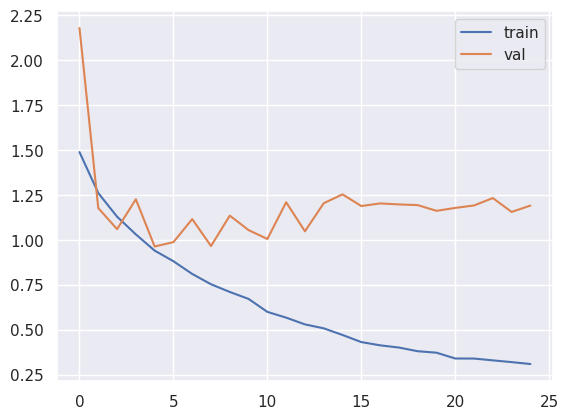

In [9]:
_, train_acc = cnn_model.evaluate(cnn_training, verbose=1)
_, val_acc = cnn_model.evaluate(cnn_val, verbose=1)
print('Train: %.3f, Val: %.3f' % (train_acc, val_acc))


2022-10-28 10:53:28.718690: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 42614784 exceeds 10% of free system memory.
2022-10-28 10:53:28.737278: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 42614784 exceeds 10% of free system memory.
2022-10-28 10:53:28.744596: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 42614784 exceeds 10% of free system memory.
2022-10-28 10:53:29.174660: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18939904 exceeds 10% of free system memory.
2022-10-28 10:53:29.182460: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18939904 exceeds 10% of free system memory.


Epoch 1/200
391/391 [==============================] - ETA: 0s - loss: 1.4890 - accuracy: 0.3352
Epoch 1: val_accuracy improved from -inf to 0.08092, saving model to /home/mcoronado/Escritorio/Models_A


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


391/391 [==============================] - 189s 477ms/step - loss: 1.4890 - accuracy: 0.3352 - val_loss: 2.1797 - val_accuracy: 0.0809 - lr: 0.0010
Epoch 2/200
391/391 [==============================] - ETA: 0s - loss: 1.2610 - accuracy: 0.4648
Epoch 2: val_accuracy improved from 0.08092 to 0.46243, saving model to /home/mcoronado/Escritorio/Models_A


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


391/391 [==============================] - 72s 184ms/step - loss: 1.2610 - accuracy: 0.4648 - val_loss: 1.1775 - val_accuracy: 0.4624 - lr: 0.0010
Epoch 3/200
391/391 [==============================] - ETA: 0s - loss: 1.1295 - accuracy: 0.5344
Epoch 3: val_accuracy improved from 0.46243 to 0.52023, saving model to /home/mcoronado/Escritorio/Models_A


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


391/391 [==============================] - 72s 185ms/step - loss: 1.1295 - accuracy: 0.5344 - val_loss: 1.0602 - val_accuracy: 0.5202 - lr: 0.0010
Epoch 4/200
391/391 [==============================] - ETA: 0s - loss: 1.0309 - accuracy: 0.5859
Epoch 4: val_accuracy did not improve from 0.52023
391/391 [==============================] - 69s 176ms/step - loss: 1.0309 - accuracy: 0.5859 - val_loss: 1.2265 - val_accuracy: 0.4335 - lr: 0.0010
Epoch 5/200
391/391 [==============================] - ETA: 0s - loss: 0.9407 - accuracy: 0.6302
Epoch 5: val_accuracy improved from 0.52023 to 0.57225, saving model to /home/mcoronado/Escritorio/Models_A


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


391/391 [==============================] - 72s 184ms/step - loss: 0.9407 - accuracy: 0.6302 - val_loss: 0.9635 - val_accuracy: 0.5723 - lr: 0.0010
Epoch 6/200
391/391 [==============================] - ETA: 0s - loss: 0.8815 - accuracy: 0.6535
Epoch 6: val_accuracy did not improve from 0.57225
391/391 [==============================] - 69s 175ms/step - loss: 0.8815 - accuracy: 0.6535 - val_loss: 0.9879 - val_accuracy: 0.5260 - lr: 0.0010
Epoch 7/200
391/391 [==============================] - ETA: 0s - loss: 0.8108 - accuracy: 0.6848
Epoch 7: val_accuracy did not improve from 0.57225
391/391 [==============================] - 68s 175ms/step - loss: 0.8108 - accuracy: 0.6848 - val_loss: 1.1160 - val_accuracy: 0.5202 - lr: 0.0010
Epoch 8/200
391/391 [==============================] - ETA: 0s - loss: 0.7533 - accuracy: 0.7107
Epoch 8: val_accuracy did not improve from 0.57225
391/391 [==============================] - 69s 175ms/step - loss: 0.7533 - accuracy: 0.7107 - val_loss: 0.9659 - va

INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
391/391 [==============================] - 72s 185ms/step - loss: 0.6717 - accuracy: 0.7444 - val_loss: 1.0549 - val_accuracy: 0.6243 - lr: 0.0010
Epoch 11/200
391/391 [==============================] - ETA: 0s - loss: 0.5996 - accuracy: 0.7764
Epoch 11: val_accuracy did not improve from 0.62428
391/391 [==============================] - 69s 175ms/step - loss: 0.5996 - accuracy: 0.7764 - val_loss: 1.0054 - val_accuracy: 0.5954 - lr: 5.0000e-04
Epoch 12/200
391/391 [==============================] - ETA: 0s - loss: 0.5675 - accuracy: 0.7904
Epoch 12: val_accuracy did not improve from 0.62428
391/391 [==============================] - 69s 176ms/step - loss: 0.5675 - accuracy: 0.7904 - val_loss: 1.2098 - val_accuracy: 0.5376 - lr: 5.0000e-04
Epoch 13/200
391/391 [==============================] - ETA: 0s - loss: 0.5300 - accuracy: 0.8082
Epoch 13: val_accuracy did not improve from 0.62428
391/391 [==============

INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


391/391 [==============================] - 73s 186ms/step - loss: 0.4011 - accuracy: 0.8610 - val_loss: 1.1978 - val_accuracy: 0.6301 - lr: 2.5000e-04
Epoch 19/200
391/391 [==============================] - ETA: 0s - loss: 0.3806 - accuracy: 0.8654
Epoch 19: val_accuracy did not improve from 0.63006
391/391 [==============================] - 69s 176ms/step - loss: 0.3806 - accuracy: 0.8654 - val_loss: 1.1939 - val_accuracy: 0.6069 - lr: 2.5000e-04
Epoch 20/200
391/391 [==============================] - ETA: 0s - loss: 0.3724 - accuracy: 0.8697
Epoch 20: val_accuracy did not improve from 0.63006

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
391/391 [==============================] - 69s 176ms/step - loss: 0.3724 - accuracy: 0.8697 - val_loss: 1.1621 - val_accuracy: 0.5838 - lr: 2.5000e-04
Epoch 21/200
391/391 [==============================] - ETA: 0s - loss: 0.3401 - accuracy: 0.8821
Epoch 21: val_accuracy did not improve from 0.63006
391/391 [==========

INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


391/391 [==============================] - 73s 185ms/step - loss: 0.3397 - accuracy: 0.8852 - val_loss: 1.1920 - val_accuracy: 0.6358 - lr: 1.2500e-04
Epoch 23/200
391/391 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0.8892
Epoch 23: val_accuracy did not improve from 0.63584
391/391 [==============================] - 69s 176ms/step - loss: 0.3297 - accuracy: 0.8892 - val_loss: 1.2331 - val_accuracy: 0.6127 - lr: 1.2500e-04
Epoch 24/200
391/391 [==============================] - ETA: 0s - loss: 0.3200 - accuracy: 0.8899
Epoch 24: val_accuracy did not improve from 0.63584
391/391 [==============================] - 69s 176ms/step - loss: 0.3200 - accuracy: 0.8899 - val_loss: 1.1560 - val_accuracy: 0.6243 - lr: 1.2500e-04
Epoch 25/200
391/391 [==============================] - ETA: 0s - loss: 0.3094 - accuracy: 0.8944
Epoch 25: val_accuracy improved from 0.63584 to 0.64162, saving model to /home/mcoronado/Escritorio/Models_A


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets


INFO:tensorflow:Assets written to: /home/mcoronado/Escritorio/Models_A/assets



Epoch 25: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 5.
391/391 [==============================] - 72s 185ms/step - loss: 0.3094 - accuracy: 0.8944 - val_loss: 1.1912 - val_accuracy: 0.6416 - lr: 1.2500e-04
Epoch 25: early stopping
